In [ ]:
import pandas as pd
import pickle
import numpy as np
from numpy import sort

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, resample

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%bigquery df
WITH MAIN AS (
  SELECT
MOBILE
,TARGET_MONTH
,SIM_MONTH_AGE
,TS
,TPV_6M
,TPV_LAST_MONTH
,TPV_SHIFT
,GAP_DAY
,COVER_SHIFT
,TOTAL_MONTH
,PT_FIX_SPEED_UL_COVER_SHIFT
,CH_OTHER_FREQ_6M
,V_3D_FREQ_SHIFT
,PT_BURST_SPEED_COVER_SHIFT
,V_3D_FREQ_6M
,PT_FIX_SPEED_UL_COVER
,CH_OTHER_FREQ_SHIFT
,PT_FIX_SPEED_UL_FREQ_SHIFT
,PT_FIX_SPEED_NS_COVER_SHIFT
,V_7D_FREQ_6M
,PT_FIX_SPEED_UL_FREQ_6M
,COVER_DAY_6M
,V_2D_FREQ_SHIFT
,V_CODE_6M
,V_2D_FREQ_6M
,SOF_WALLET_FREQ_6M
,V_CODE_SHIFT
,SOF_WALLET_FREQ_SHIFT
,PT_BURST_SPEED_COVER
,PT_BURST_SPEED_FREQ_SHIFT
,V_7D_FREQ_SHIFT
,CH_WALLET_FREQ_6M
,SOF_AIRTIME_FREQ_6M
,V_VALIDITY_6M
,RC_FLAG
  FROM `acm-bi.Analysis.SA_VAS_RECURRING_NEW_FEATURE_20210303`
)

(
  SELECT *
  FROM MAIN
  WHERE RC_FLAG = 1
  AND TARGET_MONTH <= '2020-12-01'
)
UNION ALL (
  SELECT *
  FROM MAIN 
  WHERE RC_FLAG = 0
  AND TARGET_MONTH = '2020-12-01'
)


In [5]:
df.shape

(6572219, 35)

In [6]:
def load_data(df,balance=False):
#     df = pd.read_csv(os.path.join(DATA_PATH, filename))
    df = shuffle(df)
    
    if balance == True:
        df_majority = df[df['RC_FLAG'] == 0]
        df_minority = df[df['RC_FLAG'] == 1]
        
        df_majority_downsampled = resample(df_majority,replace=False,n_samples=len(df_minority),random_state=123)

        df = pd.concat([df_majority_downsampled, df_minority])
    X = df.drop([
        'RC_FLAG'
        ,'TARGET_MONTH'
        ,'MOBILE'
    ],axis=1)
    
    y = df[['RC_FLAG']]
    mobile = df[['MOBILE']]
    return X, y, mobile

In [7]:
X,y,mobile = load_data(df)

In [8]:
y['RC_FLAG'].value_counts()

1    250779
0    250779
Name: RC_FLAG, dtype: int64

In [21]:
table = '`acm-bi.temp_auto_delete.SA_TEST_PANDAS_GBQ_TEST`'

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42)

In [10]:
print(X_train.shape)
print(X_test.shape)

(401246, 32)
(100312, 32)


In [11]:
X_train.columns

Index(['SIM_MONTH_AGE', 'TS', 'TPV_6M', 'TPV_LAST_MONTH', 'TPV_SHIFT',
       'GAP_DAY', 'COVER_SHIFT', 'TOTAL_MONTH', 'PT_FIX_SPEED_UL_COVER_SHIFT',
       'CH_OTHER_FREQ_6M', 'V_3D_FREQ_SHIFT', 'PT_BURST_SPEED_COVER_SHIFT',
       'V_3D_FREQ_6M', 'PT_FIX_SPEED_UL_COVER', 'CH_OTHER_FREQ_SHIFT',
       'PT_FIX_SPEED_UL_FREQ_SHIFT', 'PT_FIX_SPEED_NS_COVER_SHIFT',
       'V_7D_FREQ_6M', 'PT_FIX_SPEED_UL_FREQ_6M', 'COVER_DAY_6M',
       'V_2D_FREQ_SHIFT', 'V_CODE_6M', 'V_2D_FREQ_6M', 'SOF_WALLET_FREQ_6M',
       'V_CODE_SHIFT', 'SOF_WALLET_FREQ_SHIFT', 'PT_BURST_SPEED_COVER',
       'PT_BURST_SPEED_FREQ_SHIFT', 'V_7D_FREQ_SHIFT', 'CH_WALLET_FREQ_6M',
       'SOF_AIRTIME_FREQ_6M', 'V_VALIDITY_6M'],
      dtype='object')

In [12]:
y_train['RC_FLAG'].value_counts()

1    200699
0    200547
Name: RC_FLAG, dtype: int64

# Xgboost Model

In [13]:
model = xgb.XGBClassifier(importance_type='weight')
model.fit(X_train, y_train)

[19:15:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='weight', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
pred_prob = model.predict_proba(X_test)

In [15]:
acc = accuracy_score(y_test, predictions)
f1_acc = f1_score(y_test, predictions)

In [16]:
print('ACCURACY :', acc)
print('F1 SCORE :', f1_acc)

ACCURACY : 0.6840258393811308
F1 SCORE : 0.6874346685600458


In [26]:
model = xgb.XGBClassifier(verbosity = 0,importance_type="weight")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc_score = accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" % (acc_score * 100))

import numpy as np
thresh = np.sort(model.feature_importances_)

for t in thresh:
    select = SelectFromModel(model,threshold=t,prefit=True)
    select_xtrain = select.transform(X_train)

    select_model = xgb.XGBClassifier(verbosity = 0)
    select_model.fit(select_xtrain,y_train)

    select_xtest = select.transform(X_test)
    y_pred_new = select_model.predict(select_xtest)
    z = [round(value) for value in y_pred_new]
    acc_score = accuracy_score(y_test,z)
    pre_score = precision_score(y_test,z)
    rec_score = recall_score(y_test,z)
    f_score = f1_score(y_test, z)

    print('Thresh=%.3f, n=%d, Accuracy: %.2f%% F-Score: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (t,select_xtest.shape[1],acc_score*100,f_score*100,pre_score,rec_score))

Accuracy: 68.47%
Thresh=0.000, n=118, Accuracy: 68.47% F-Score: 68.58% Precision: 0.68% Recall: 0.69%
Thresh=0.000, n=118, Accuracy: 68.47% F-Score: 68.58% Precision: 0.68% Recall: 0.69%
Thresh=0.000, n=118, Accuracy: 68.47% F-Score: 68.58% Precision: 0.68% Recall: 0.69%
Thresh=0.000, n=118, Accuracy: 68.47% F-Score: 68.58% Precision: 0.68% Recall: 0.69%
Thresh=0.000, n=118, Accuracy: 68.47% F-Score: 68.58% Precision: 0.68% Recall: 0.69%
Thresh=0.000, n=118, Accuracy: 68.47% F-Score: 68.58% Precision: 0.68% Recall: 0.69%
Thresh=0.000, n=118, Accuracy: 68.47% F-Score: 68.58% Precision: 0.68% Recall: 0.69%
Thresh=0.000, n=111, Accuracy: 68.47% F-Score: 68.58% Precision: 0.68% Recall: 0.69%
Thresh=0.000, n=111, Accuracy: 68.47% F-Score: 68.58% Precision: 0.68% Recall: 0.69%
Thresh=0.000, n=109, Accuracy: 68.49% F-Score: 68.65% Precision: 0.68% Recall: 0.69%
Thresh=0.001, n=108, Accuracy: 68.49% F-Score: 68.65% Precision: 0.68% Recall: 0.69%
Thresh=0.001, n=108, Accuracy: 68.49% F-Score: 6

In [29]:
importances = list(zip(model.feature_importances_, X_train))
importances.sort(reverse=True)
print('Feature,Score')
for item in importances:
    print(','.join([str(item[1]), str(item[0])]))

Feature,Score
SIM_MONTH_AGE,0.08216927
TS,0.04211175
TPV_6M,0.030197207
TPV_LAST_MONTH,0.029375514
TPV_SHIFT,0.027732128
GAP_DAY,0.02198028
COVER_SHIFT,0.021158587
TOTAL_MONTH,0.020542318
PT_FIX_SPEED_UL_COVER_SHIFT,0.019720625
CH_OTHER_FREQ_6M,0.019104354
V_3D_FREQ_SHIFT,0.017666392
PT_BURST_SPEED_COVER_SHIFT,0.017666392
V_3D_FREQ_6M,0.016639277
PT_FIX_SPEED_UL_COVER,0.015817584
CH_OTHER_FREQ_SHIFT,0.015612161
PT_FIX_SPEED_UL_FREQ_SHIFT,0.015201314
PT_FIX_SPEED_NS_COVER_SHIFT,0.015201314
V_7D_FREQ_6M,0.014585045
PT_FIX_SPEED_UL_FREQ_6M,0.014585045
COVER_DAY_6M,0.014585045
V_2D_FREQ_SHIFT,0.014379622
V_CODE_6M,0.014174199
V_2D_FREQ_6M,0.014174199
SOF_WALLET_FREQ_6M,0.01355793
V_CODE_SHIFT,0.01232539
SOF_WALLET_FREQ_SHIFT,0.0121199675
PT_BURST_SPEED_COVER,0.011914544
PT_BURST_SPEED_FREQ_SHIFT,0.011709121
V_7D_FREQ_SHIFT,0.011503697
CH_WALLET_FREQ_6M,0.011503697
SOF_AIRTIME_FREQ_6M,0.011298275
V_VALIDITY_6M,0.011092851
V_VALIDITY_SHIFT,0.0106820045
CH_WEB_FREQ_SHIFT,0.010476582
V_TYPE_SH

In [30]:
for item in importances[:32]:
    print(','+str(item[1]))

,SIM_MONTH_AGE
,TS
,TPV_6M
,TPV_LAST_MONTH
,TPV_SHIFT
,GAP_DAY
,COVER_SHIFT
,TOTAL_MONTH
,PT_FIX_SPEED_UL_COVER_SHIFT
,CH_OTHER_FREQ_6M
,V_3D_FREQ_SHIFT
,PT_BURST_SPEED_COVER_SHIFT
,V_3D_FREQ_6M
,PT_FIX_SPEED_UL_COVER
,CH_OTHER_FREQ_SHIFT
,PT_FIX_SPEED_UL_FREQ_SHIFT
,PT_FIX_SPEED_NS_COVER_SHIFT
,V_7D_FREQ_6M
,PT_FIX_SPEED_UL_FREQ_6M
,COVER_DAY_6M
,V_2D_FREQ_SHIFT
,V_CODE_6M
,V_2D_FREQ_6M
,SOF_WALLET_FREQ_6M
,V_CODE_SHIFT
,SOF_WALLET_FREQ_SHIFT
,PT_BURST_SPEED_COVER
,PT_BURST_SPEED_FREQ_SHIFT
,V_7D_FREQ_SHIFT
,CH_WALLET_FREQ_6M
,SOF_AIRTIME_FREQ_6M
,V_VALIDITY_6M


# Evaluate Jan'21

In [37]:
%%bigquery df_eval
SELECT
MOBILE
,TARGET_MONTH
,SIM_MONTH_AGE
,TS
,TPV_6M
,TPV_LAST_MONTH
,TPV_SHIFT
,GAP_DAY
,COVER_SHIFT
,TOTAL_MONTH
,PT_FIX_SPEED_UL_COVER_SHIFT
,CH_OTHER_FREQ_6M
,V_3D_FREQ_SHIFT
,PT_BURST_SPEED_COVER_SHIFT
,V_3D_FREQ_6M
,PT_FIX_SPEED_UL_COVER
,CH_OTHER_FREQ_SHIFT
,PT_FIX_SPEED_UL_FREQ_SHIFT
,PT_FIX_SPEED_NS_COVER_SHIFT
,V_7D_FREQ_6M
,PT_FIX_SPEED_UL_FREQ_6M
,COVER_DAY_6M
,V_2D_FREQ_SHIFT
,V_CODE_6M
,V_2D_FREQ_6M
,SOF_WALLET_FREQ_6M
,V_CODE_SHIFT
,SOF_WALLET_FREQ_SHIFT
,PT_BURST_SPEED_COVER
,PT_BURST_SPEED_FREQ_SHIFT
,V_7D_FREQ_SHIFT
,CH_WALLET_FREQ_6M
,SOF_AIRTIME_FREQ_6M
,V_VALIDITY_6M
,RC_FLAG


FROM `acm-bi.Analysis.SA_VAS_RECURRING_NEW_FEATURE_20210303`
WHERE TARGET_MONTH = '2021-01-01'

In [38]:
import math
def generate_prediction_set(df,batch=300000):
    df = shuffle(df)
    
    loop = math.ceil(len(df)/batch)
    
    batch_predict = []
    for i in range(0,loop):
#         print(i*batch,(i*batch)+batch)
        df_temp = df[i*batch:(i*batch)+batch]
#         X_temp = df_temp[[
#             'SIM_DAY_AGE',
#             'TS',
#             'TPV_6M',
#             'COVER_DAY_6M',
#             'SOF_OTHER_FREQ_6M',
#             'PT_FIX_SPEED_UL_COVER_6M',
#             'V_7D_FREQ_6M',
#             'SOF_WALLET_FREQ_6M',
#             'PT_BURST_SPEED_COVER_6M',
#             'V_2D_FREQ_6M',
#             'PT_FIX_SPEED_UL_FREQ_6M',
#             'V_3D_FREQ_6M',
#             'V_1D_FREQ_6M',
#             'PT_FIX_SPEED_NS_COVER_6M',
#             'CH_WALLET_FREQ_6M',
#             'CH_WEB_FREQ_6M',
#         ]]
        X_temp = df_temp.drop([
            'RC_FLAG'
            ,'TARGET_MONTH'
            ,'MOBILE'
        ],axis=1)
        y = df_temp[['RC_FLAG']]
        mobile = df_temp[['MOBILE']]
        
        batch_predict.append((X_temp,y,mobile))
    return batch_predict

In [39]:
batch_predict = generate_prediction_set(df_eval,500000)

In [40]:
for i,batch in enumerate(batch_predict):
    pred = model.predict(batch[0])
    predictions_eval = np.array([round(value) for value in pred])
    acc = accuracy_score(batch[1], predictions_eval)
    f1_acc = f1_score(batch[1], predictions_eval)
    
    total_rc = len(batch[1][batch[1]['RC_FLAG']==1])
    total_nonrc = len(batch[1][batch[1]['RC_FLAG']==0])
    print(f'Batch {i} RC_FLAG {total_rc} NONRC_FLAG {total_nonrc} ACCURACY : {acc} F1 SCORE: {f1_acc}')

Batch 0 RC_FLAG 6621 NONRC_FLAG 493379 ACCURACY : 0.672502 F1 SCORE: 0.03993879022754322
Batch 1 RC_FLAG 6664 NONRC_FLAG 493336 ACCURACY : 0.673352 F1 SCORE: 0.03960954957073975
Batch 2 RC_FLAG 6607 NONRC_FLAG 493393 ACCURACY : 0.670676 F1 SCORE: 0.038739506590853366
Batch 3 RC_FLAG 6577 NONRC_FLAG 493423 ACCURACY : 0.672206 F1 SCORE: 0.039318894522434866
Batch 4 RC_FLAG 6621 NONRC_FLAG 493379 ACCURACY : 0.672204 F1 SCORE: 0.04030869763792438
Batch 5 RC_FLAG 6578 NONRC_FLAG 493422 ACCURACY : 0.671622 F1 SCORE: 0.038790504346807954
Batch 6 RC_FLAG 6471 NONRC_FLAG 493529 ACCURACY : 0.672154 F1 SCORE: 0.03902004349890666
Batch 7 RC_FLAG 6592 NONRC_FLAG 493408 ACCURACY : 0.671004 F1 SCORE: 0.03895633478611406
Batch 8 RC_FLAG 6565 NONRC_FLAG 493435 ACCURACY : 0.672118 F1 SCORE: 0.04047829471429325
Batch 9 RC_FLAG 6649 NONRC_FLAG 493351 ACCURACY : 0.670842 F1 SCORE: 0.03937545600466948
Batch 10 RC_FLAG 6487 NONRC_FLAG 493513 ACCURACY : 0.67222 F1 SCORE: 0.0390952051501542
Batch 11 RC_FLAG 65

In [41]:
X_eval, y_eval, mobile = load_data(df_eval)

pred = model.predict(X_eval)
predictions_eval = np.array([round(value) for value in pred])

acc = accuracy_score(y_eval, predictions_eval)
f1_acc = f1_score(y_eval, predictions_eval)

print('ACCURACY :', acc)
print('F1 SCORE :', f1_acc)

ACCURACY : 0.6718964293873056
F1 SCORE : 0.03935356426896408


In [42]:
# df_eval['PROB'] = model.predict_proba(X_eval)
prob_result = model.predict_proba(X_eval)
df_eval['PROB'] = prob_result[:,1:]
df_result = df_eval[['MOBILE','RC_FLAG','PROB']]

In [43]:
DATA_PATH = '../data'
df_result.to_csv(os.path.join(DATA_PATH, 'new_rc_result.csv'),index=False)

In [44]:
print(len(predictions_eval[predictions_eval==0]))
print(len(predictions_eval[predictions_eval==1]))

4159998
2034037


In [45]:
y_eval['RC_FLAG'].value_counts()

0    6112533
1      81502
Name: RC_FLAG, dtype: int64

In [46]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [47]:
confusion_matrix(y_eval,predictions_eval)

array([[4120123, 1992410],
       [  39875,   41627]])

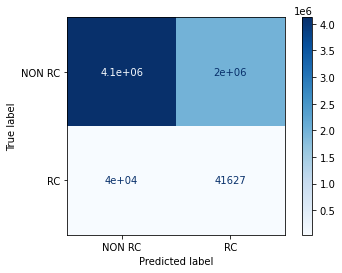

In [48]:
disp = plot_confusion_matrix(model, X_eval, y_eval,
                             display_labels=['NON RC', 'RC'],
                             cmap=plt.cm.Blues,)

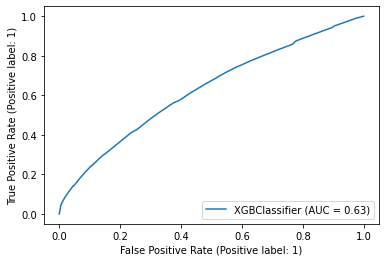

In [49]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model, X_eval, y_eval) 

In [50]:
print(len(predictions_eval[predictions_eval==1]))

2034037


In [51]:
import scikitplot as skplt

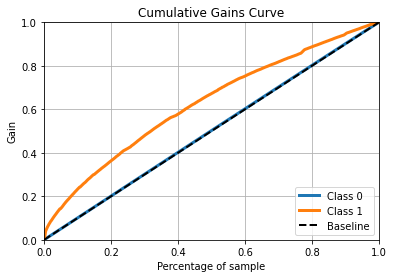

In [52]:
skplt.metrics.plot_cumulative_gain(y_eval, prob_result)
plt.show()

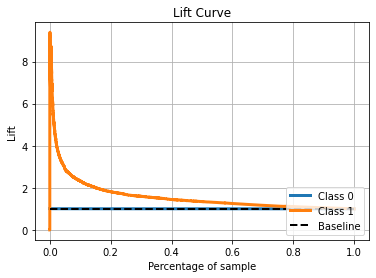

In [53]:
skplt.metrics.plot_lift_curve(y_eval, prob_result)
plt.show()

In [ ]:
df_eval[]